In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import statsmodels.api as sm

from util.clean import rinse_listings 
from util.utils import regplot, plot_map, boolean_to_boolean, currency_to_number


# The business questions
More data and better algorithms are typically thought to optimize the earnings of any service due to a more complete understanding of the market. Or from economic theory, a more enlightened market. So, as a home owner listing your apartment on AirBnB, is there any gains to be made by utilising and adapting to the market? To look into this, I have posed three questions and investigated it in this document and the exploration notebooks found in the repo. The questions are the following: 

* Is there a need to reduce the price for a longer stay, say 1 week compared to 7 separate days?
* Is it a potential to utilise seaonality to increase the overall earnings in periods of high demand?
* On which time scales does the seasonality in pricing occur?


In [3]:
#Import Listings
df_seattle_list = pd.read_csv('input/seattle/listings.csv')
print(df_seattle_list.shape)
df_seattle_list.head(5)

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
#Import calendar.csv
df_seattle_cal = pd.read_csv('input/seattle/calendar.csv', parse_dates=[1])
print(df_seattle_cal.shape)
df_seattle_cal.head(5)

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


# First cleaning
Let's first do some initial cleaning based on the exploration we did in "exploration_listing.ipynb". It showed many columns that have all unique values (categorical or ordinal), or just 1 unique value. This will be removed below. Also, a selection of columns with text or not immediately interesting information is removed to reduce the clutter. At last columns with percentage, currency or boolean values are formatted to useful values. 

We are left with a dataframe that are not free for NaN values, but is possible to work with. 

In [5]:
df_rinsed_listing = rinse_listings(df_seattle_list)

Index(['id', 'listing_url', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'latitude', 'longitude'],
      dtype='object')


In [6]:
df_rinsed_listing

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,2011-08-11,within a few hours,0.96,1.0,0.0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",...,10.0,10.0,9.0,10.0,False,moderate,False,False,2,4.07
1,953595,5177328,2013-02-21,within an hour,0.98,1.0,1.0,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",...,10.0,10.0,10.0,10.0,False,strict,True,True,6,1.48
2,3308979,16708587,2014-06-12,within a few hours,0.67,1.0,0.0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",...,10.0,10.0,10.0,10.0,False,strict,False,False,2,1.15
3,7421966,9851441,2013-11-06,NaN,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",...,NaN,NaN,NaN,NaN,False,flexible,False,False,1,NaN
4,278830,1452570,2011-11-29,within an hour,1.00,NaN,0.0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",...,10.0,10.0,9.0,9.0,False,strict,False,False,1,0.89
5,5956968,326758,2010-12-25,NaN,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",...,10.0,10.0,10.0,10.0,False,strict,False,False,1,2.45
6,1909058,2497928,2012-05-30,within an hour,1.00,1.0,1.0,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",...,10.0,10.0,10.0,10.0,False,moderate,False,False,1,2.46
7,856550,4016632,2012-10-30,within an hour,1.00,1.0,1.0,5.0,5.0,"['email', 'phone', 'facebook', 'google', 'link...",...,10.0,10.0,9.0,10.0,False,strict,True,True,5,4.73
8,4948745,2166277,2012-04-18,NaN,NaN,1.0,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'linkedin', 're...",...,10.0,9.0,10.0,10.0,False,strict,False,False,1,1.22
9,2493658,5177328,2013-02-21,within an hour,0.98,1.0,1.0,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",...,10.0,10.0,10.0,9.0,False,strict,True,True,6,1.55


In [7]:
df_rinsed_listing.count()/df_rinsed_listing.shape[0]

id                                  1.000000
host_id                             1.000000
host_since                          0.999476
host_response_time                  0.863017
host_response_rate                  0.863017
host_acceptance_rate                0.797538
host_is_superhost                   0.999476
host_listings_count                 0.999476
host_total_listings_count           0.999476
host_verifications                  1.000000
host_identity_verified              0.999476
neighbourhood                       0.891042
neighbourhood_cleansed              1.000000
neighbourhood_group_cleansed        1.000000
zipcode                             0.998167
latitude                            1.000000
longitude                           1.000000
is_location_exact                   1.000000
property_type                       0.999738
room_type                           1.000000
accommodates                        1.000000
bathrooms                           0.995809
bedrooms  

## The price 
We will have a look at the different price columns in the data. There seems to be given a daily price, or just price, a weekly price offer and a monthly price offer. In addition, information about the security deposit and cleaning fee is given. Some correlations here should be given. 

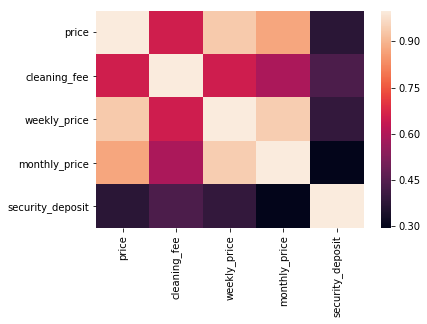

In [8]:
price_cols = ['price', 'cleaning_fee', 'weekly_price', 'monthly_price', 'security_deposit']
corr = df_rinsed_listing[price_cols].corr()
sns.heatmap(corr)

First of all, the security deposity is basically uncorrelated to the daily price. Hard to say why, and probably not the most interesting observation. The cleaning fee is also relatively loosely correlated with the price columns and we will not look further into those. However, as expected there is a strong correlation between the price column, weekly price column and monthly price column. It is also possible to observe that it is a stronger correlation between the price and weekly price column, than the price and monthly price column. Why? Is it so that you get a discount for renting a place longer and thus the price deviation is bigger for the monthly price?

Let's look into that. 

C:\Anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


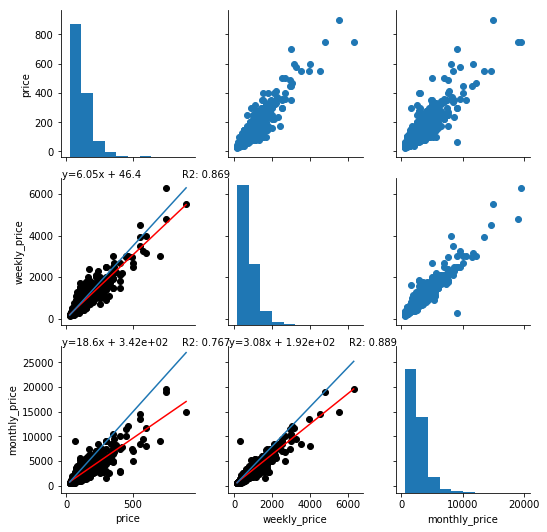

In [9]:
price_cols = ['price', 'weekly_price', 'monthly_price']

g = sns.PairGrid(data=df_rinsed_listing.dropna(axis=0, how='any', subset=price_cols)[price_cols])
g.map_upper(plt.scatter)
g.map_diag(plt.hist)
g.map_lower(regplot)

In the plot above, we can see the histogram of the different price columns on the diagonal. More interestingly is the lower diagonal which shows the scatter of points as black dots. The blue line shows a trend line which for the weekly price is given by y=7*price and for the monthly price is given by y=30*price. Basically, these blue lines are the price you would expect if you rent 7 or 30 separate consecutive days. The red lines are the linear regression line of the black dots. Thus, showing the average multiple. 

In both monthly and weekly price it is possible to see that the red line is giving a lower price than the N consective days in the blue line, indicating that you will get a discount by renting a longer period as expect from typical economies of scale principles. However, there are still a significant amount of listings which is priced above the multiple daily price on especially the weekly price. 

In [10]:
df_rinsed_listing['pricePerBed'] = df_rinsed_listing['price']/df_rinsed_listing['beds']
df_rinsed_listing['monthlyPricePerBed'] = df_rinsed_listing['monthly_price']/df_rinsed_listing['beds']
df_rinsed_listing['weeklyPricePerBed'] = df_rinsed_listing['weekly_price']/df_rinsed_listing['beds']
df_rinsed_listing['margin'] = (df_rinsed_listing['weekly_price']/(df_rinsed_listing['price']*7))-1

mean_nea = df_rinsed_listing.groupby('neighbourhood_cleansed').mean().reset_index()
for col in mean_nea[['margin', 'neighbourhood_cleansed']].drop('neighbourhood_cleansed', axis=1):
    plot_map(mean_nea, 'neighbourhood_cleansed', col, 'nhood_clean', bins=[-0.35, -0.25, -0.15, -0.05, 0, 0.05])

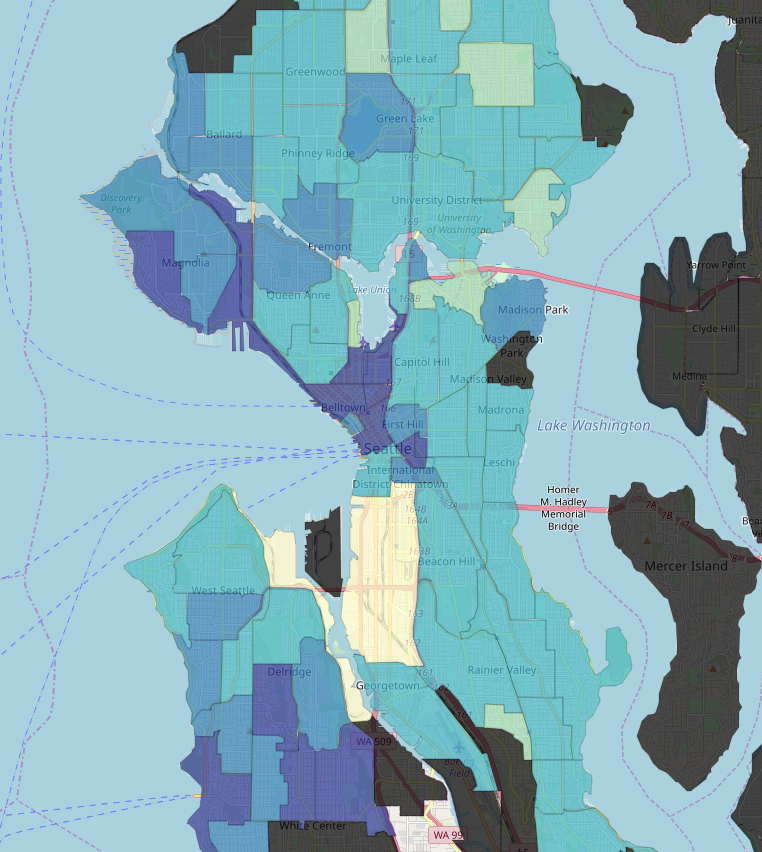

In [11]:
from IPython.display import Image
Image("nhood_clean_test_margin_dump.png")

From the above map (the exerpt is hiding the scale) we can see the weekly price margin per area in Seattle. The dark areas shows a positive margin, which means the weekly price is higher than renting for 7 separate consequtive days. 

## Seasonality

Looking into the calendar file we get more insight into how the price varies around the year. FIrst we need to clean up the table somewhat. The availability is given as a t an f and the prices are given with a dollar sign. Thus we reformat: 

In [12]:
df_seattle_cal['available'] = df_seattle_cal['available'].map(boolean_to_boolean)
df_seattle_cal['price'] = df_seattle_cal['price'].map(currency_to_number)
df_seattle_cal.head(15)

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN
5,241032,2016-01-09,False,NaN
6,241032,2016-01-10,False,NaN
7,241032,2016-01-11,False,NaN
8,241032,2016-01-12,False,NaN
9,241032,2016-01-13,True,85.0


By looking at the sum of values not Nan in the date and price column we see that there is a direct relationship between the false values and having 0 price values. 

In [13]:
count_vals = df_seattle_cal.groupby(by=['listing_id','available']).count()
days_unavailable = count_vals.loc[(slice(None),slice(0,0)), :].sort_values(by='date', ascending=False)['date'].reset_index(level=1,drop=True).rename('days_unavailable')
print(count_vals)

                      date  price
listing_id available             
3335       False        56      0
           True        309    309
4291       True        365    365
5682       False        56      0
           True        309    309
6606       True        365    365
7369       False       312      0
           True         53     53
9419       True        365    365
9460       False       308      0
           True         57     57
9531       False       185      0
           True        180    180
9534       False       103      0
           True        262    262
9596       False         2      0
           True        363    363
10385      True        365    365
10695      True        365    365
11012      True        365    365
11411      True        365    365
13068      False        21      0
           True        344    344
14386      False        49      0
           True        316    316
15108      False        59      0
           True        306    306
17951      Fal

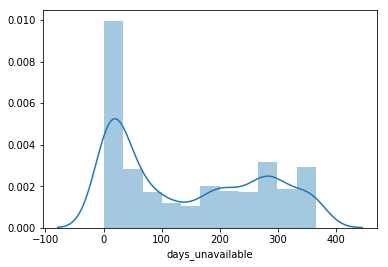

In [14]:
sns.distplot(days_unavailable)

It can also be seen from the above plot that the number of days unavailable are spread out, with quite a chunk having all days of the year available. However, how is this spread out over the year?

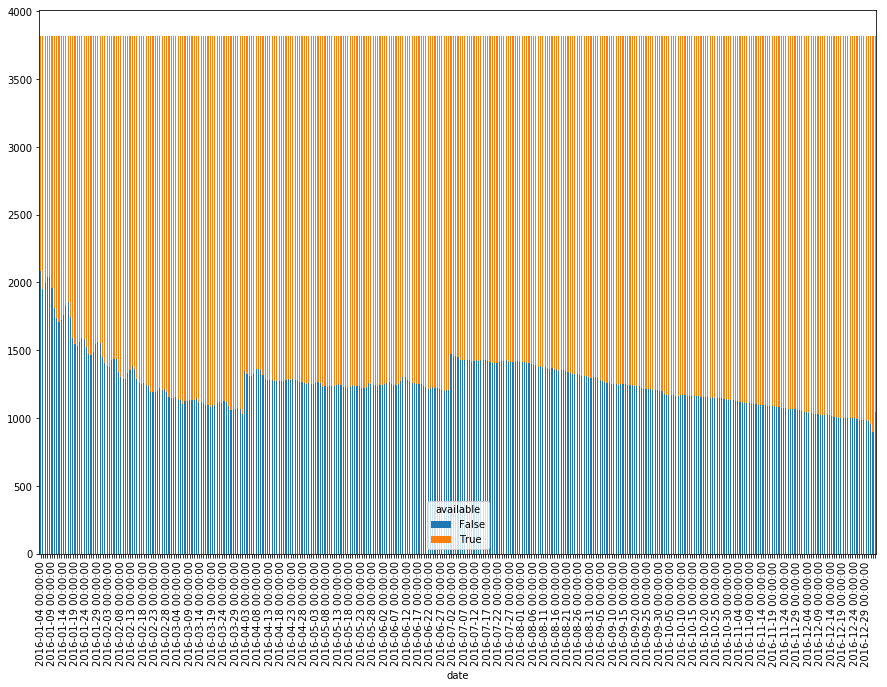

In [15]:
date_grouped = df_seattle_cal.groupby(by=['date', 'available']).count()
ax = date_grouped.unstack()['listing_id'].plot(kind='bar', figsize=(15,10), stacked=True)
for label in ax.xaxis.get_ticklabels()[::]:
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::5]:
    label.set_visible(True)

Well, the available and unavailble dates are quite evenly spread out. As expected there are a few spikes in the unavailability around March/April and July. This could probably be related to the typical holiday seasons. Also, as expected, there is less availability in near future. 

So lets assume it is ok to keep all listings for now and we'll have a look at some aggregated numbers over the year. First we'll create a price index which will be related to the mean price over the year for each listing. This way we can compare the price development on all the listings over the year.

In [16]:
df_seattle_cal['price_index'] = 1
for id_ in df_seattle_cal['listing_id'].unique():
    sub_df = df_seattle_cal.loc[df_seattle_cal['listing_id']==id_,['price', 'listing_id']]
    df_seattle_cal.loc[df_seattle_cal['listing_id']==id_, 'price_index'] = sub_df['price']/sub_df['price'].mean()

Text(0, 0.5, 'Price index - standard deviation')

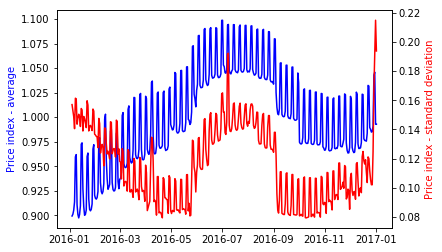

In [36]:
mean_index = df_seattle_cal.groupby('date').mean()
std_index = df_seattle_cal.groupby('date').std()
fig,ax = plt.subplots(1,1)
ax.plot(mean_index.reset_index()['date'], mean_index['price_index'], 'b')
ax.set_ylabel('Price index - average', color='b')
ax2 = ax.twinx()
ax2.plot(std_index.reset_index()['date'], std_index['price_index'], 'r')
ax2.set_ylabel('Price index - standard deviation', color='r')

From investigation of the price index we see several interesting things. First of all, there is a very bumpy, and cyclic, feature in it. Secondly, the average pricing goes up over the summer, and so does the standard deviation. Meaning that the spread in pricing index increase between listings over summer. So some people take advantage of the high season, others don't seem to do it as well. Thirdly, it seems to be a very gradual trend in average pricing shift from winter to summer, with a significant spike in the standard deviation around new years eve, which probably indicate that some owners are very aware of their listing being popular for a new years stay. 

We can go a bit further on the seasonality by using the statsmodels library. 

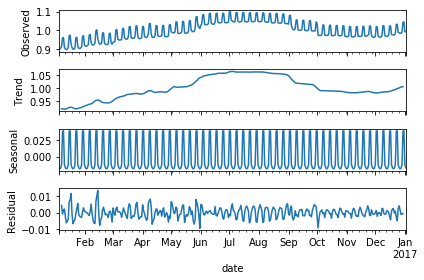

In [37]:
result = sm.tsa.seasonal_decompose(mean_index['price_index'])
result.plot();
plt.savefig('Season.png')

The seasonal decompose function tries to strip away the cyclic pattern, called seasonal, from the underlying trend. Since we only have 1 year of data we cannot talk about seasonality over the year as that would require many years of data. However, we see a very clear seasonal component on a much shorter time scale. 

THe trend shows the increase in price over summer months, but it also shows clearer an increase in price over the last part of december. Clearly a holiday thing.

The residual shows the noise of the signal, which is actually not very significant. Most of the signal can be described by the trend and seasonal component. 

We see that the seasonal component is very stable throughout the year. Every x days the price bumps by 5% and the it drops. How can this be?

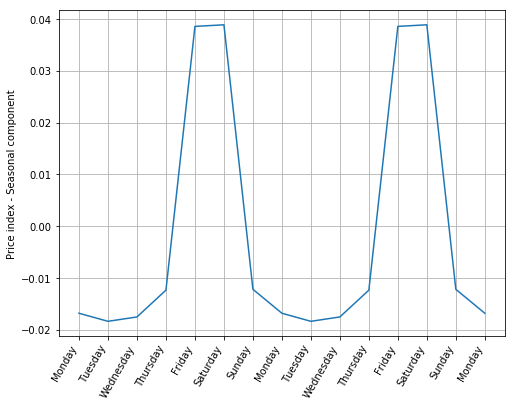

In [38]:

fig, ax = plt.subplots(1,1, figsize=(8,6))
dates = result.seasonal.index
days = dates.day_name()
days
ax.plot(dates[:15], result.seasonal.values[:15])
# Set major x ticks on Mondays.
ax.set_ylabel('Price index - Seasonal component')
ax.set_xticklabels(ax.get_xticks(),rotation=60, horizontalalignment='right')
ax.xaxis.set_major_locator(
    matplotlib.dates.DayLocator()
)
ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%A')
)
plt.grid()
plt.savefig('Weekly_season.png')

Well, look at this, it is the weekend effect. Interestingly consistent, and probably governed by an algorithm made by AirBnb?

Let's try to look at the monthly development of the price index. By plotting a boxplot we can understand a lot in one plot about the distribution and skewness of the plots. The filled boxes shows the upper and lower quartile. The dots shows outliers. It clearly shows that the median price is higher in the summer, and that even the 25% lowest value is above an index of 1. However, it also shows that there are significant numbers of outliers, with much higher and lower values. 

You can also see that in May and September the spread is small, and quite centered around the mean price for each listing. Meaning those are kind of tipping months. 

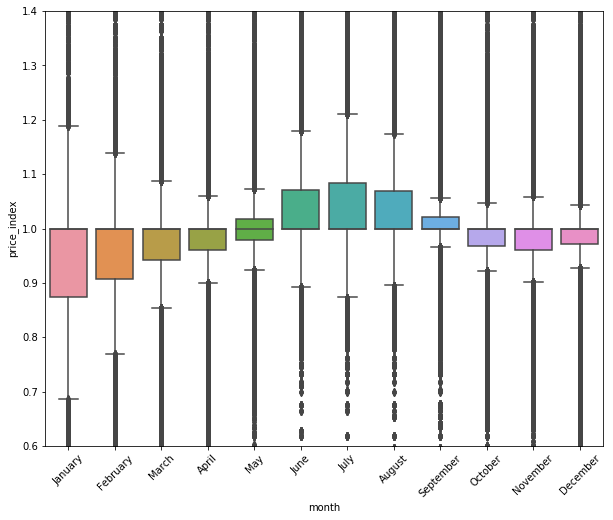

In [41]:
df_seattle_cal['month'] = df_seattle_cal['date'].apply(lambda x: x.strftime("%B"))
df_seattle_cal['month_num'] = df_seattle_cal['date'].apply(lambda x: x.month)
df_seattle_cal['week_num'] = df_seattle_cal['date'].apply(lambda x: x.strftime('%W'))

fig, ax = plt.subplots(1,1, figsize=(10,8))

sns.boxplot(x='month', y='price_index', data= df_seattle_cal.dropna(subset=['price_index']), ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.ylim(0.6, 1.4)
plt.savefig('Monthly_price_index.png')

<BarContainer object of 19 artists>

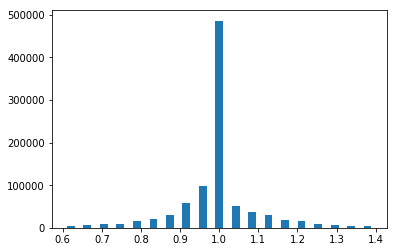

In [58]:
bins = 70

df_int = df_seattle_cal.copy()
df_int['price_index_interval'] = pd.cut(df_seattle_cal['price_index'], np.linspace(0.6, 1.4, 20))
grouped = df_int.groupby('price_index_interval').count().reset_index()
grouped['price_index_int'] = grouped['price_index_interval'].apply(lambda x: x.mid)
plt.bar(grouped['price_index_int'], grouped['price_index'], width=0.02)

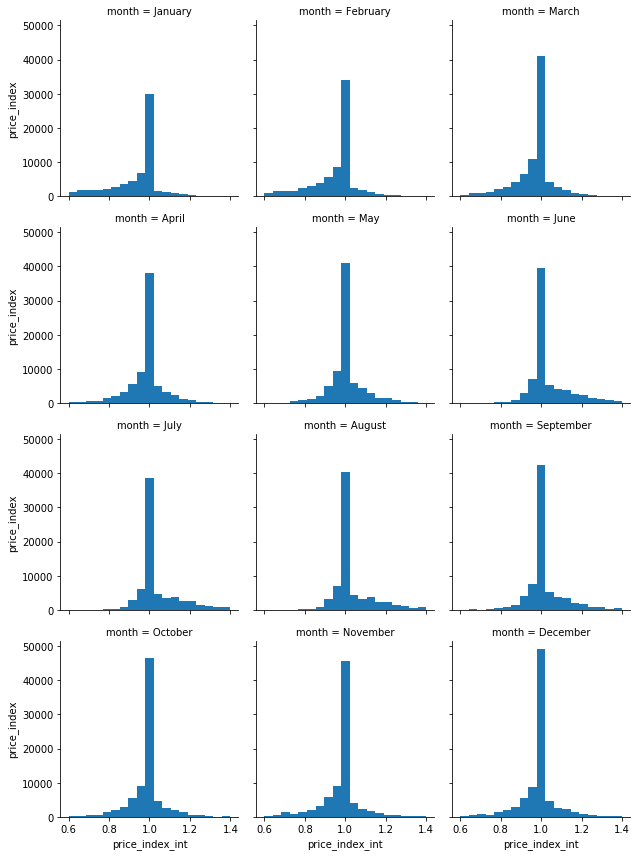

In [43]:
grouped = df_int.groupby(by=['month', 'price_index_interval']).count().reset_index()
grouped['price_index_int'] = grouped['price_index_interval'].apply(lambda x: x.mid)
g=sns.FacetGrid(grouped, col='month', col_wrap=3, col_order=df_int[['month', 'month_num']].groupby('month').mean().sort_values(by='month_num').reset_index()['month'])
g.map(plt.bar, 'price_index_int', 'price_index', width=df_int['price_index_interval'].unique()[0].length)
plt.savefig('Monthly price index count.png')